# Stereo tracking

## Without occlusions

Path in .gitignore for sample without occlusions is in tracking/conveyor_sample_without 
and 

can be downloaded 
<a href="https://dtudk-my.sharepoint.com/personal/evanb_dtu_dk/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fevanb%5Fdtu%5Fdk%2FDocuments%2FCourses%2F31392%2FFinal%5FProject%2Fsample%5FStereo%5Fconveyor%5Fwithout%5Focclusions%2Erar&parent=%2Fpersonal%2Fevanb%5Fdtu%5Fdk%2FDocuments%2FCourses%2F31392%2FFinal%5FProject&ga=1">Here</a>

The whole conveyor belt dataset without occlusions downloaded <a href="https://dtudk-my.sharepoint.com/personal/evanb_dtu_dk/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fevanb%5Fdtu%5Fdk%2FDocuments%2FCourses%2F31392%2FFinal%5FProject%2FStereo%5Fconveyor%5Fwithout%5Focclusions%2Erar&parent=%2Fpersonal%2Fevanb%5Fdtu%5Fdk%2FDocuments%2FCourses%2F31392%2FFinal%5FProject&ga=1">Here</a>

Dataset conveyor with occlusions can be downloaded <a href="https://dtudk-my.sharepoint.com/personal/evanb_dtu_dk/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fevanb%5Fdtu%5Fdk%2FDocuments%2FCourses%2F31392%2FFinal%5FProject%2FStereo%5Fconveyor%5Fwith%5Focclusions%2Erar&parent=%2Fpersonal%2Fevanb%5Fdtu%5Fdk%2FDocuments%2FCourses%2F31392%2FFinal%5FProject&ga=1">Here</a>

First I´ll try sparse optical flow from Week 2. I will track where the object is and then use the depth map from previous task to aquire the depth = Z coordinate


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#show in popup
# %matplotlib qt
#show inlince
%matplotlib inline

## Functions

### Load images, one by one

In [2]:
import cv2
import numpy as np
import glob



def optical_flow(path, show_windows=True, no_of_frames=0, resize=False, scale=1, display_OF=False):
    """ sensitivity in pixels to discard noise"""

    xs = []
    ys = []



    images = glob.glob(path)
    assert images != [], "No images found in {}".format(path)
    
    first_frame = cv2.imread(images[0])
    if resize: first_frame = cv2.resize(first_frame, (0, 0), fx=scale, fy=scale)
    print("Dimensions:", first_frame.shape, "\n")
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(first_frame)
    mask[..., 1] = 255

    #write if else statement on one line
    
    if no_of_frames == 0:   no_of_frames = len(images)-1
    esle:                   no_of_frames = no_of_frames

    for i in range(1, no_of_frames):
        if i == 1:  prev_frame = first_frame #for displaying only
        else:   
            prev_frame = cv2.imread(images[i-1])
            if resize: prev_frame = cv2.resize(prev_frame, (0,0), fx=scale, fy=scale)

        next_frame = cv2.imread(images[i])
        if resize: next_frame = cv2.resize(next_frame, (0,0), fx=scale, fy=scale)
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY) #convert to grayscale

        flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0) #calculate dence OF

        if display_OF:
            mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1]) # Retrieving the magnitude and angle of every pixel
            mask = np.zeros_like(prev_frame) # Create empty matrix in dimesions as original image
            mask[..., 1] = 255              # Set image saturation to maximum value as we do not need it
            mask[..., 0] = ang*180/np.pi/2  # Set image hue according to the optical flow direction
            mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

        h, w = flow.shape[:2]
        fx, fy = flow[:,:,0], flow[:,:,1]
        ang = np.arctan2(fy, fx) + np.pi
        v = np.sqrt(fx*fx+fy*fy)

        hsv = np.zeros((h, w, 3), np.uint8)
        hsv[...,0] = ang*(90/np.pi/2)
        hsv[...,1] = 255
        hsv[...,2] = np.minimum(v*4, 255)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        gray1 = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray1, 3 , 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        # loop over the contours
        for c in cnts:
            M = cv2.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            centroid = (cx,cy)
            area = cv2.contourArea(c)
            #print area

            areaTH = 5000
            if resize: areaTH = areaTH*scale**2

            # if the contour is too small, ignore it
            (x, y, w, h) = cv2.boundingRect(c)
            a = x + w
            b = y + h
            #display text in the window centroid
            if area > areaTH:
                cv2.putText(next_frame, "Area: {}".format(area), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                cv2.putText(next_frame, "Centroid: ({}, {})".format(cx, cy), (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                cv2.putText(next_frame, "Height: {}".format(h), (x, y+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                cv2.putText(next_frame, "Width: {}".format(w), (x, y+60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                cv2.rectangle(next_frame, (x, y), (a , b ), (0, 255, 0), 2)
                cv2.circle(next_frame,(cx,cy),5,(0,0,255), -1)

                # For kalman
                xs.append(cx)
                ys.append(cy)




                
            # if (area > areaTH) and (area < areaTH2) and (w < 400) and (h < 600) :
        
        
        if display_OF:  flow = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR) #convert to RGB for display
        if show_windows: 
            if display_OF:  out = cv2.addWeighted(next_frame, 1, flow, 2, 0)
            else:           out = next_frame
            cv2.imshow('frame', out)
        if cv2.waitKey(1) & 0xFF == ord('q'): #stop on q
            break
        prev_gray = next_gray #update from previous frame
        print("\rFrame {}/{}".format(i, no_of_frames+1), end="")

    cv2.destroyAllWindows() #close all windows
    

    return xs, ys


### Running the code

In [3]:
#PARAMETERS
display = True  #whether to display the windows
# path_OF = "conveyor_sample_without/left/*.png"    #sample video without occlusions
path_OF = "video/sample/left/*.png"        #Full video without occlusions
# path_OF = "conveyor_full_with/left/*.png"         #full video with occlusions

display_OF = True   #whether to display the optical flow
no_of_frames = 0    #how many images to use. Use 0 for all
resize = False       #resize for quicker run. BE CAREFUL! Cant use resizing for depth, also OF is not accurate
scale = 1         #resize by this factor 
xs, ys = optical_flow(path=path_OF, show_windows=display, no_of_frames=no_of_frames, 
            resize=resize, scale=scale, display_OF=display_OF)


Dimensions: (720, 1280, 3) 

Frame 128/130

### Kalman testing

In [4]:
from kalman import *
%run kalman.py

In [8]:
measurements = np.vstack((np.asarray(xs), np.asarray(ys)))
measurements.shape

(2, 127)

In [10]:

filtered = offline_kalman(measurements)
filtered.shape

(4, 127)

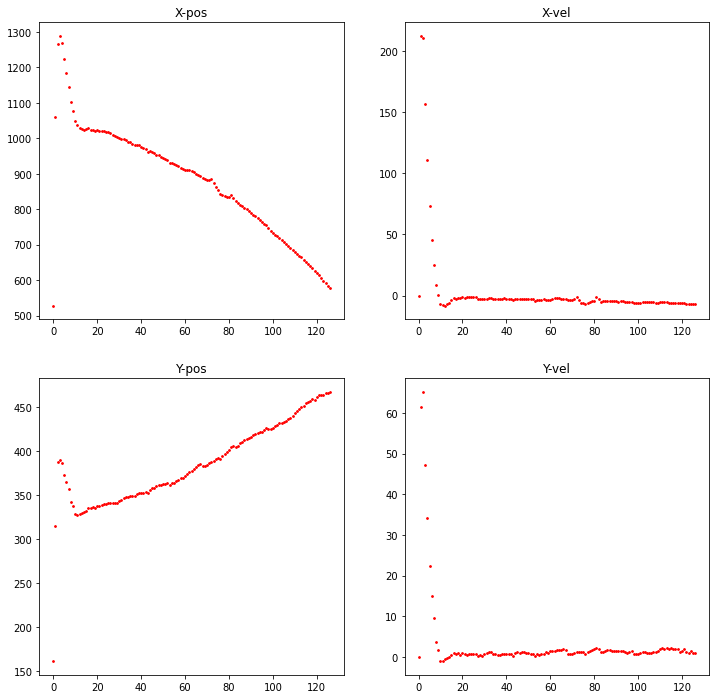

In [16]:
time = np.arange(0,len(xs), 1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs[0, 0].scatter(time, filtered[0, :], s=3, c="red") # X-pos
axs[0, 0].set_title("X-pos")
axs[0, 1].scatter(time, filtered[1, :], s=3, c="red") # X-vel
axs[0, 1].set_title("X-vel")
axs[1, 0].scatter(time, filtered[2, :], s=3, c="red") # Y-pos
axs[1, 0].set_title("Y-pos")
axs[1, 1].scatter(time, filtered[3, :], s=3, c="red") # Y-vel
axs[1, 1].set_title("Y-vel");
